# NoisePy4DAS: SeaDAS-N as an example

- Yiyu Ni (niyiyu@uw.edu)
- Department of Earth and Space Sciences, University of Washington

- Project URL: 
    - https://github.com/niyiyu/DASstore
    - https://github.com/chengxinjiang/NoisePy_4DAS
    - https://github.com/niyiyu/NoisePy4DAS-SeaDAS
    
- SCEC Cyber Training for Seismology (May 9 - 12, 2023) 
    - https://seisscoped.org/HPS/
    
- More about SeaDAS-N experiment at Photonic Sensing Facility (PSF)
  - https://psf.uw.edu (Lead PI: Brad Lipovsky)
    
- Last updated: May 8, 2023

#### SeaDAS-N
(a) Map showing the location of the SeaDAS-N cable (solid line) connecting Seattle and Bothell campus of the University of Washington in Seattle, Washington, United States. Only the red segment was used during December 2022 for data collection. (b) One-hour SeaDAS-N raw data (in radians) of all 2089 channels. The Sintela Onyx interrogator unit samples at 100 Hz, with 4.78-meter channel spacing and 9.56-meter gauge length. The example plot starts 2022-12-15 13:30:00 UTC. The gray region indicates a one-minute data gap. The clipped sub-array (channel $\sim$1100-1700) is from the segment where the cable is above the ground.

**If you run the tutorial through docker, or if you clone the repo, run the cell below**

In [2]:
# on Docker/local
import sys
sys.path.append("../src")
sys.path.append("../DASstore") 

In [3]:
import os
import time
from datetime import datetime, timedelta
from dateutil.parser import parse

import h5py
import numpy as np
import DAS_module
import matplotlib.pyplot as plt
from tqdm import tqdm

from dasstore.zarr import Client
from TDMS_Read import TdmsReader

In [4]:
# t0 = time.time()
# t1 = time.time()
# MY CHANGES: 

# hf = h5py.File('../../../temp_data_store/FirstData_UTC_20231109_134117.573.h5', 'r')

file_path = "../../../temp_data_store/FirstData_UTC_20231109_134117.573.tdms"
tdms_file = TdmsReader(file_path)
tdms_file._read_properties()

n_channels = tdms_file.fileinfo['n_channels']
cha1, cha2 = 0, n_channels-1


# END CHANGES

In [5]:
alldata = tdms_file.get_data(cha1, cha2)
properties = tdms_file.get_properties()

# for prop in properties:
#     print(prop)

cha_spacing = properties.get('SpatialResolution[m]') * properties.get('Fibre Length Multiplier')
start_dist, stop_dist = properties.get('Start Distance (m)'), properties.get('Stop Distance (m)')
sps = properties.get('SamplingFrequency[Hz]')
spatial_res = properties.get('SpatialResolution[m]')

# time_1 = datetime.strptime(file_path.split('/')[-1].split('UTC_')[-1].split('.')[0], '%Y%m%d_%H%M%S')
time_1 = properties.get('GPSTimeStamp')
time_delta = timedelta(seconds=tdms_file.channel_length / sps)
time_2 = time_1 + time_delta
print(time_1, time_2)


print(type(alldata))
print(f"data is of shape {alldata.shape}")
# print(f"it takes %.3f seconds to download data" % (t1 - t0))

2023-11-09 13:41:17.573756 2023-11-09 13:41:27.573756
<class 'numpy.ndarray'>
data is of shape (10000, 9088)


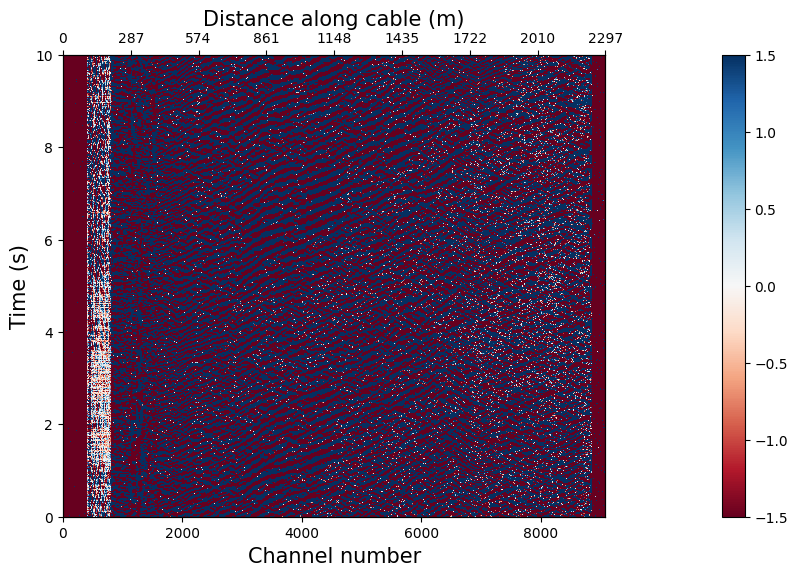

In [6]:
plt.figure(figsize = (10, 6), dpi = 100)
plt.imshow(alldata, aspect='auto', extent=[cha1, cha2, 0, time_delta.seconds],
           cmap='RdBu', vmax=1.5, vmin=-1.5, origin='lower')
plt.xlabel("Channel number", fontsize=15)
plt.ylabel("Time (s)", fontsize=15)
plt.xlim([cha1, cha2])

twinx = plt.gca().twiny()
twinx.set_xticks(np.linspace(0, 2000, 9),
                 [int(i* cha_spacing) for i in np.linspace(0, 9000, 9)])
twinx.set_xlabel("Distance along cable (m)", fontsize=15)
plt.colorbar(pad = 0.15)

## 3 cross-correlate with NoisePy4DAS
### 3.1 parameters

In [7]:
sps       = properties.get('SamplingFrequency[Hz]')                 # current sampling rate
samp_freq = 100                                                     # targeted sampling rate
freqmin   = 1                                                       # pre filtering frequency bandwidth
freqmax   = 49.9                                                    # note this cannot exceed Nquist freq

freq_norm   = 'rma'             # 'no' for no whitening, or 'rma' for running-mean average, 'phase_only' for sign-bit normalization in freq domain.
time_norm   = 'one_bit'         # 'no' for no normalization, or 'rma', 'one_bit' for normalization in time domain
cc_method   = 'xcorr'           # 'xcorr' for pure cross correlation, 'deconv' for deconvolution; FOR "COHERENCY" PLEASE set freq_norm to "rma", time_norm to "no" and cc_method to "xcorr"
smooth_N    = 100               # moving window length for time domain normalization if selected (points)
smoothspect_N  = 100            # moving window length to smooth spectrum amplitude (points)
maxlag      = 8                 # lags of cross-correlation to save (sec)

# criteria for data selection
max_over_std = 10               # threahold to remove window of bad signals: set it to 10*9 if prefer not to remove them

cc_len = 60                     # correlate length in second
step   = 60                     # stepping length in second


cha_list = np.array(range(cha1, cha2)) 
nsta = len(cha_list) + 1
n_pair = int((nsta+1)*nsta/2)
n_lag = maxlag * samp_freq * 2 + 1

prepro_para = {'freqmin':freqmin,
               'freqmax':freqmax,
               'sps':sps,
               'npts_chunk':cc_len*sps,
               'nsta':nsta,
               'cha_list':cha_list,
               'samp_freq':samp_freq,
               'freq_norm':freq_norm,
               'time_norm':time_norm,
               'cc_method':cc_method,
               'smooth_N':smooth_N,
               'smoothspect_N':smoothspect_N,
               'maxlag':maxlag,
               'max_over_std':max_over_std}

# # you can save this parameter file to local
# metadata = os.path.join(CCFDIR, 'prepro_fft_info.txt')
# # output parameter info
# fout = open(metadata,'w')
# fout.write(str(prepro_para));fout.close()

### 3.2 get data

In [9]:
# need to stitch files together to 60s samples+
dir_path = "../../../temp_data_store/"
tdms_array = np.empty(len(os.listdir(dir_path)), TdmsReader)

for count, file in enumerate(os.listdir(dir_path)):
    if file.endswith('.tdms'):
        tdms_array[count] = TdmsReader(dir_path + file)

dates = []
for tdms in tdms_array:
    props = tdms.get_properties()
    dates.append(props.get('GPSTimeStamp'))

tdms_array = [x for y, x in sorted(zip(np.array(dates), tdms_array))]

current_time = 0
minute_data = np.empty((alldata.shape[0] * 6, n_channels))
while current_time != 60 and len(tdms_array) != 0:
    data = tdms_array.pop(0).get_data(cha1, cha2)
    current_row = current_time * 1000
    minute_data[current_row:current_row+10000, :] = data
    current_time += time_delta.seconds
    

print(f"one minute of sub-array data is of shape {minute_data.shape}")

(10000, 9088)
one minute of sub-array data is of shape (60000, 9088)


In [9]:
# runs out of memory v sad

# plt.figure(figsize = (10, 5), dpi = 100)
# plt.imshow(minute_data, aspect = 'auto', 
#            cmap = 'RdBu', vmax = 1.5, vmin = -1.5, origin='lower')
# _ =plt.yticks(np.linspace(cha1, cha2, 4) - cha1, 
#               [int(i) for i in np.linspace(cha1, cha2, 4)], fontsize = 12)
# plt.ylabel("Channel number", fontsize = 15)
# plt.xlabel("Time", fontsize = 15)
# twiny = plt.gca().twinx()
# twiny.set_yticks(np.linspace(0, cha2 - cha1, 4), 
#                              [int(i* cha_spacing) for i in np.linspace(cha1, cha2, 4)])
# twiny.set_ylabel("Distance along cable (m)", fontsize = 15)
# plt.colorbar(pad = 0.1)

: 

### 3.3 pre-processing

In [8]:
trace_stdS, dataS = DAS_module.preprocess_raw_make_stat(minute_data, prepro_para)

plt.figure(figsize = (10, 5), dpi = 100)
plt.imshow(dataS, aspect = 'auto', 
           cmap = 'RdBu', vmax = 1.5, vmin = -1.5, origin='lower')
_ =plt.yticks(np.linspace(cha1, cha2, 4) - cha1, 
              [int(i) for i in np.linspace(cha1, cha2, 4)], fontsize = 12)
plt.ylabel("Channel number", fontsize = 15)
plt.xlabel("Time", fontsize = 15)
twiny = plt.gca().twinx()
twiny.set_yticks(np.linspace(0, cha2 - cha1, 4), 
                             [int(i* cha_spacing) for i in np.linspace(cha1, cha2, 4)])
twiny.set_ylabel("Distance along cable (m)", fontsize = 15)
plt.colorbar(pad = 0.1)

: 

### 3.4 FFT, temporal and frequency normalizaiton (if specified)

In [17]:
white_spect = DAS_module.noise_processing(dataS, prepro_para)
Nfft = white_spect.shape[1]; Nfft2 = Nfft // 2
data = white_spect[:, :Nfft2]
# del dataS, white_spect

print(data.shape, data.dtype)

(500, 1500) complex64


### 3.5 channel-pair selection

In [18]:
ind = np.where((trace_stdS < prepro_para['max_over_std']) &
                        (trace_stdS > 0) &
                (np.isnan(trace_stdS) == 0))[0]
if not len(ind):
    raise ValueError('the max_over_std criteria is too high which results in no data')
sta = cha_list[ind]
white_spect = data[ind]

print(white_spect.shape, white_spect.dtype)

(432, 1500) complex64


### 3.6 cross-correlate over all channel pairs

In [19]:
# loop over all stations
for iiS in range(len(sta)):
    # smooth the source spectrum
    sfft1 = DAS_module.smooth_source_spect(white_spect[iiS], prepro_para)

    # correlate one source with all receivers
    corr, tindx = DAS_module.correlate(sfft1, white_spect[iiS:], prepro_para, Nfft)
    
    print(f"source channel index: {sta[iiS]}, correlation shape: {corr.shape}")

source channel index: 500, correlation shape: (432, 801)
source channel index: 501, correlation shape: (431, 801)
source channel index: 502, correlation shape: (430, 801)
source channel index: 503, correlation shape: (429, 801)
source channel index: 504, correlation shape: (428, 801)
source channel index: 505, correlation shape: (427, 801)
source channel index: 506, correlation shape: (426, 801)
source channel index: 507, correlation shape: (425, 801)
source channel index: 508, correlation shape: (424, 801)
source channel index: 509, correlation shape: (423, 801)
source channel index: 510, correlation shape: (422, 801)
source channel index: 511, correlation shape: (421, 801)
source channel index: 512, correlation shape: (420, 801)
source channel index: 513, correlation shape: (419, 801)
source channel index: 514, correlation shape: (418, 801)
source channel index: 515, correlation shape: (417, 801)
source channel index: 516, correlation shape: (416, 801)
source channel index: 517, corr

## 4 10-minute linear stacking
We create this `corr_full` and `stack_full` matrix to store a sub-stacking results. More specifically, we linearly stack each minute of correlation in memory, and only save the hourly stacking to the CCF storage (local ASDF, S3, etc.)

In [20]:
corr_full = np.zeros([n_lag, n_pair], dtype = np.float32)
stack_full = np.zeros([1, n_pair], dtype = np.int32)
task_t0 = datetime(year = 2022, month = 12, day = 1, 
                   hour = 0, minute = 0, second = 0, microsecond = 0)

n_minute = 10

We loop over all data chunk. Reminder that the data is on the cloud, and computing is made on this server. So we are downloading the data as we compute at the same time (async option?)

In [21]:
# each task is one minute
n_minute = 1
pbar = tqdm(range(n_minute))
t_query = 0; t_compute = 0
for imin in pbar:
    t0 = time.time()
    pbar.set_description(f"Processing {task_t0}")
    task_t0 += timedelta(minutes = 1)
    tdata = client.get_data(cha_list, 
            starttime = task_t0,
            endtime = task_t0 + timedelta(minutes = 1)).T
    t_query += time.time() - t0

    t1 = time.time()
    # perform pre-processing
    trace_stdS, dataS = DAS_module.preprocess_raw_make_stat(tdata, prepro_para)

    # do normalization if needed
    white_spect = DAS_module.noise_processing(dataS, prepro_para)
    Nfft = white_spect.shape[1]; Nfft2 = Nfft // 2
    data = white_spect[:, :Nfft2]
    del dataS, white_spect

    ind = np.where((trace_stdS < prepro_para['max_over_std']) &
                            (trace_stdS > 0) &
                    (np.isnan(trace_stdS) == 0))[0]
    if not len(ind):
        raise ValueError('the max_over_std criteria is too high which results in no data')
    sta = cha_list[ind]
    white_spect = data[ind]

    # loop over all stations
    for iiS in range(len(sta)):
        # smooth the source spectrum
        sfft1 = DAS_module.smooth_source_spect(white_spect[iiS], prepro_para)
        
        # correlate one source with all receivers
        corr, tindx = DAS_module.correlate(sfft1, white_spect[iiS:], prepro_para, Nfft)

        # update the receiver list
        tsta = sta[iiS:]
        receiver_lst = tsta[tindx]

        iS = int((cha2*2 - cha1 - sta[iiS] + 1) * (sta[iiS] - cha1) / 2)

        # stacking one minute
        corr_full[:, iS + receiver_lst - sta[iiS]] += corr.T
        stack_full[:, iS + receiver_lst - sta[iiS]] += 1
        
    t_compute += time.time() - t1
corr_full /= stack_full
print("%.3f seconds in data query, %.3f seconds in xcorr computing" % (t_query, t_compute))

Processing 2022-12-01 00:00:00: 100%|██████████| 1/1 [00:16<00:00, 16.93s/it]

9.459 seconds in data query, 7.471 seconds in xcorr computing



/tmp/ipykernel_25834/608331376.py:51: RuntimeWarning: invalid value encountered in divide
  corr_full /= stack_full


## 5 visualize and save CCF 

Text(0, 0.5, 'Distance along cable (m)')

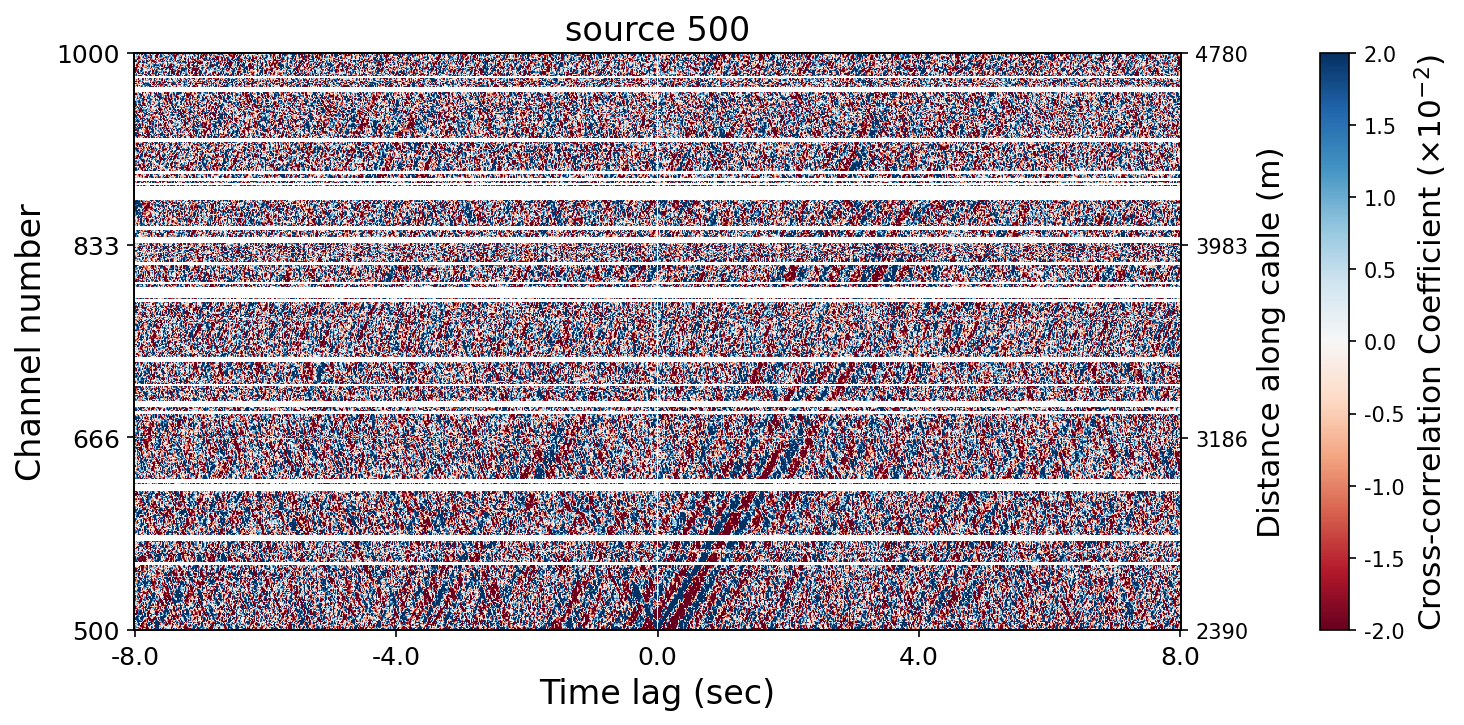

In [22]:
plt.figure(figsize = (12, 5), dpi = 150)

plt.imshow(corr_full[:, :(cha2 - cha1)].T, aspect = 'auto', cmap = 'RdBu', 
           vmax = 2e-2, vmin = -2e-2, origin = 'lower', interpolation=None)

_ =plt.yticks(np.linspace(cha1, cha2, 4) - cha1, 
              [int(i) for i in np.linspace(cha1, cha2, 4)], fontsize = 12)
_ = plt.xticks(np.arange(0, 801, 200), (np.arange(0, 801, 200) - 400)/50, fontsize = 12)
plt.ylabel("Channel number", fontsize = 16)
plt.xlabel("Time lag (sec)", fontsize = 16)
plt.title("source 500", fontsize = 16)
bar = plt.colorbar(pad = 0.1, format = lambda x, pos: '{:.1f}'.format(x*100))
bar.set_label('Cross-correlation Coefficient ($\\times10^{-2}$)', fontsize = 15)

twiny = plt.gca().twinx()
twiny.set_yticks(np.linspace(0, cha2 - cha1, 4), 
                             [int(i* cha_spacing) for i in np.linspace(cha1, cha2, 4)])
twiny.set_ylabel("Distance along cable (m)", fontsize = 15)

### 5.1 ASDF (Adaptable Seismic Data Format)
The adaptable seismic data format (ASDF; Krischer et al., 2016) is one of such file formats that uses the HDF5 container to store large time series and metadata. NoisePy takes advantages of ASDF for a structured organization of the cross-correlation data while maintaining the parallel I/O capabilities (Jiang et al., 2020)

In [23]:
import pyasdf

t0 = time.time()
with pyasdf.ASDFDataSet("./CCF.h5", mpi = False) as ccf_ds:
    for iiS in tqdm(range(len(sta))):
        for iiR in range(nsta - iiS):
            # use the channel number as a way to figure out distance
            Sindx = iiS + cha1
            iS = int((cha2*2 - cha1 - Sindx + 1) * (Sindx - cha1) / 2)
            param = {'sps':samp_freq,
                    'dt': 1/samp_freq,
                    'maxlag':maxlag,
                    'freqmin':freqmin,
                    'freqmax':freqmax}

            # source-receiver pair
            data_type = str(sta[iiS])
            path = f'{Sindx}_{Sindx + iiR}'
            ccf_ds.add_auxiliary_data(data=corr_full[:, iS + iiR], 
                                      data_type=data_type, 
                                      path=path, 
                                      parameters=param)
t1 = time.time()
print(f"it takes %.3f seconds to write this ASDF file" % (t1 - t0))

  0%|          | 0/443 [00:00<?, ?it/s]

100%|██████████| 443/443 [01:11<00:00,  6.20it/s]

it takes 71.465 seconds to write this ASDF file


### 5.2 TileDB

In [1]:
import tiledb

t0 = time.time()
dim1 = tiledb.Dim(name="time_lag", domain=(0, n_lag-1), tile=n_lag, dtype=np.uint32, 
                  filters = tiledb.FilterList([tiledb.DoubleDeltaFilter(),tiledb.GzipFilter(level=-1)]))
dim2 = tiledb.Dim(name="channel_pair", domain=(0, n_pair-1), tile=100, dtype=np.uint32,
                  filters = tiledb.FilterList([tiledb.DoubleDeltaFilter(),tiledb.GzipFilter(level=-1)]))

rawdata = tiledb.Attr(name="CCF", dtype=np.float32, 
                  filters=tiledb.FilterList([tiledb.ByteShuffleFilter(), tiledb.LZ4Filter(level = 5)]),
                     fill=np.nan)

dom = tiledb.Domain(dim1, dim2)
schema = tiledb.ArraySchema(domain=dom, sparse=False, attrs=[rawdata])

tiledb.Array.create(f"./CCF.tdb", schema = schema)

with tiledb.open(f"./CCF.tdb", 'w') as A:
    A[:, :] = corr_full
    
t1 = time.time()
print(f"it takes %.3f seconds to write this TileDB file" % (t1 - t0))

ModuleNotFoundError: No module named 'tiledb'

In [24]:
!du -h CCF.tdb

  0B	CCF.tdb/__meta
  0B	CCF.tdb/__labels
  0B	CCF.tdb/__fragment_meta
  0B	CCF.tdb/__commits
4.0K	CCF.tdb/__schema
358M	CCF.tdb/__fragments/__1683318534358_1683318534358_5c6de3a8f9c841c6858c4f12fede1f33_18
358M	CCF.tdb/__fragments
358M	CCF.tdb


### 5.3 TileDB.S3
**There is the option to write TileDB directly to AWS S3 bucket.** So basically one can avoid writing local files (e.g., ASDF), but write from RAM to S3 directly. This is especially efficient when running xcorr jobs on AWS in a way that you don't need to have much local storage for the instance running sub-tasks (e.g., EBS).

In [21]:
# create a configuration object
config = tiledb.Config()

# set configuration parameters
config["vfs.s3.scheme"] = "https"
config["vfs.s3.region"] = "us-west-2"
config["vfs.s3.endpoint_override"] = ""
config["vfs.s3.use_virtual_addressing"] = "true"
config["vfs.s3.aws_access_key_id"] = "YOUR_AWS_ACCESS_KEY"
config["vfs.s3.aws_secret_access_key"] =  "YOUR_AWS_SECRET_ACCESS_KEY"
    
# create contex
ctx = tiledb.Ctx(config)

bucket = "s3://seisscoped-hps"

with tiledb.open(f"./CCF.tdb", 'w', ctx = ctx) as A:
    A[:, :] = corr_full

# EOF

In [2]:
def correlate(fft1_smoothed_abs,fft2,D,Nfft):
    import scipy
    #----load paramters----
    sps     = D['samp_freq']
    dt      = 1/sps
    maxlag  = D['maxlag']
    method  = D['cc_method']
    smoothspect_N = D['smoothspect_N']

    nwin  = fft2.shape[0]
    Nfft2 = fft2.shape[1]

    #------convert all 2D arrays into 1D to speed up--------
    corr = np.zeros(nwin*Nfft2,dtype=np.complex64)
    fft1 = np.repeat(fft1_smoothed_abs.reshape(1,fft1_smoothed_abs.size), nwin, axis = 0)  # duplicate fft1_smoothed_abs for nwin rows
    corr = fft1.reshape(fft1.size,)*fft2.reshape(fft2.size,)

    corr  = corr.reshape(nwin,Nfft2)

    # loop through each cross correlation
    ampmax = np.zeros(nwin,dtype=np.float32)

    crap   = np.zeros(shape=(nwin, Nfft), dtype=np.complex64)
    crap[:, :Nfft2] = corr
    crap[:, :Nfft2] -= np.mean(crap[:, :Nfft2], axis=-1, keepdims=True)
    crap[:, -(Nfft2)+1:] = np.flip(np.conj(crap[:, 1:(Nfft2)]), axis=-1)
    # crap[:, 0] = complex(0,0)
    s_corr = scipy.fftpack.ifftshift(scipy.fftpack.ifft(crap, Nfft, axis = -1), axes = -1).real

    # remove abnormal trace
    ampmax = np.max(s_corr,axis=1)
    tindx  = np.where( (ampmax<20*np.median(ampmax)) & (ampmax>0))[0]
    s_corr = s_corr[tindx,:]

    t = np.arange(-Nfft2,Nfft2)*dt
    ind = np.where(np.abs(t) <= maxlag)[0]
    if s_corr.ndim==1:
        s_corr = s_corr[ind]
    elif s_corr.ndim==2:
        s_corr = s_corr[:,ind]
    return s_corr,tindx

In [3]:
plt.figure(figsize = (12, 5), dpi = 100)

plt.imshow(corr_full[:, :(cha2 - cha1)].T, aspect = 'auto', cmap = 'RdBu', 
           vmax = 2e-2, vmin = -2e-2, origin = 'lower', interpolation=None)

_ =plt.yticks(np.linspace(cha1, cha2, 4) - cha1, 
              [int(i) for i in np.linspace(cha1, cha2, 4)], fontsize = 12)
_ = plt.xticks(np.arange(0, 801, 200), (np.arange(0, 801, 200) - 400)/50, fontsize = 12)
plt.ylabel("Channel number", fontsize = 16)
plt.xlabel("Time lag (sec)", fontsize = 16)
plt.title("source 500", fontsize = 16)
bar = plt.colorbar(pad = 0.1, format = lambda x, pos: '{:.1f}'.format(x*100))
bar.set_label('Cross-correlation Coefficient ($\\times10^{-2}$)', fontsize = 15)

twiny = plt.gca().twinx()
twiny.set_yticks(np.linspace(0, cha2 - cha1, 4), 
                             [int(i* cha_spacing) for i in np.linspace(cha1, cha2, 4)])
twiny.set_ylabel("Distance along cable (m)", fontsize = 15)

NameError: name 'plt' is not defined